In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


#Import Data

In [ ]:
df = pd.read_excel('Online Retail.xlsx')  
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


#Clean Data

In [3]:
# Remove rows with missing customer IDs
df = df[df['CustomerID'].notnull()]

# Remove cancelled transactions (Invoice numbers starting with 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Remove rows with quantity or price <= 0
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]


#Add a Column for Total Price

In [4]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


Define a reference date for recency

In [5]:
import datetime as dt

reference_date = df['InvoiceDate'].max() + dt.timedelta(days=1)


Calculate RFM for each customer

In [6]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',     # Frequency
    'TotalPrice': 'sum'         # Monetary
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


Score Each Metric from 1-5

In [7]:
# Recency: lower is better
rfm['R_score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])

# Frequency & Monetary: higher is better
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M_score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])


In [8]:
rfm['RFM_Score'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)
rfm.head()


,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score
CustomerID,,,,,,,
12346.0,326,1,77183.60,1,1,5,115
12347.0,2,7,4310.00,5,5,5,555
12348.0,75,4,1797.24,2,4,4,244
12349.0,19,1,1757.55,4,1,4,414
12350.0,310,1,334.40,1,1,2,112


Segment the Customer

In [10]:
def segment(row):
    r = int(row['R_score'])
    f = int(row['F_score'])
    m = int(row['M_score'])

    if r == 5 and f == 5 and m == 5:
        return 'Best Customers'
    elif r >= 4 and f >= 4:
        return 'Loyal Customers'
    elif r == 5:
        return 'Recent Customers'
    elif f == 5:
        return 'Frequent Buyers'
    elif m == 5:
        return 'Big Spenders'
    elif r <= 2:
        return 'At Risk'
    else:
        return 'Others'

rfm['Segment'] = rfm.apply(segment, axis=1)
rfm.head()


,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score,Segment
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,1,5,115,Big Spenders
12347.0,2,7,4310.00,5,5,5,555,Best Customers
12348.0,75,4,1797.24,2,4,4,244,At Risk
12349.0,19,1,1757.55,4,1,4,414,Others
12350.0,310,1,334.40,1,1,2,112,At Risk


Suggest marketing strategies for each group:

Visualization


Heatmap of RFM groups

C:\Users\Admin\AppData\Local\Temp\ipykernel_35936\2159422348.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rfm_group = rfm.groupby(['R_score', 'F_score']).size().unstack()


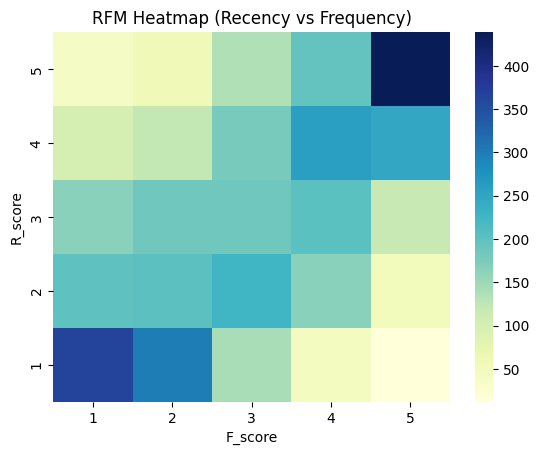

In [11]:
rfm_group = rfm.groupby(['R_score', 'F_score']).size().unstack()
sns.heatmap(rfm_group, cmap="YlGnBu")
plt.title('RFM Heatmap (Recency vs Frequency)')
plt.show()

Bar Charts For Segments

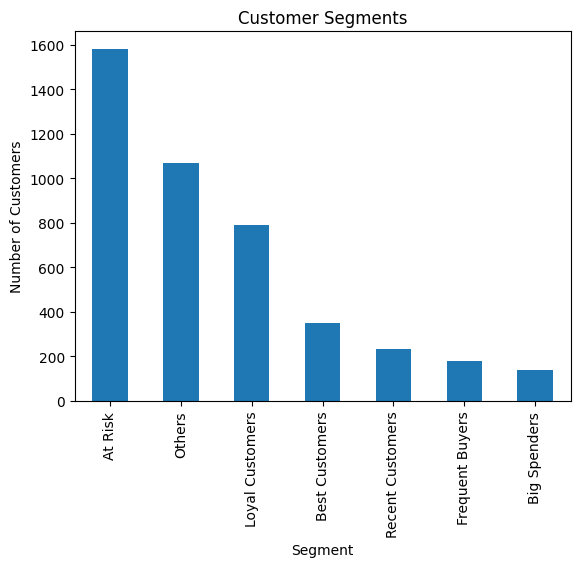

In [12]:
rfm['Segment'].value_counts().plot(kind='bar')
plt.title('Customer Segments')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.show()
